# [COM6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**2 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**3 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**1 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**1 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**3 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  (**10 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 12 Apr 2024** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [105]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [106]:
# load the data
train_data = pd.read_csv("./data_topic/train.csv",names=["label","text"])
dev_data = pd.read_csv("./data_topic/dev.csv",names=["label","text"])
test_data = pd.read_csv("./data_topic/test.csv",names=["label","text"])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [107]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [108]:
ngram_range = (1,1) # setup the range of n-grams for comparison

def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):

    # Tokenize the text based on the provided pattern
    tokens = re.findall(token_pattern, x_raw)

    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    
    # Initialize list to store the resulting n-grams
    x = []
    
    # Generate n-grams for each n in the specified range
    for n in range(ngram_range[0], ngram_range[1] + 1):
        # For unigrams, the tokens list is already what we need
        if n == 1:
            ngrams = tokens
        else:
            # For n > 1, generate n-grams
            ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        
        # Filter n-grams based on the vocab, if provided
        if vocab:
            ngrams = [ngram for ngram in ngrams if ngram in vocab]
        
        # Append the n-grams to the result list
        x.extend(ngrams)

    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [109]:
def get_vocab(X_raw, ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    # Initialize Counters to store document frequency (DF) and raw ngram counts
    df = Counter()  # Document Frequency (DF) of n-grams
    ngram_counts = Counter()  # Raw frequency of n-grams

    # Process each document
    for document in X_raw:
        # Extract n-grams from the document
        ngrams_in_doc = extract_ngrams(document, ngram_range, token_pattern, stop_words)
        
        # Update total ngram counts
        ngram_counts.update(ngrams_in_doc)
        
        # Update document frequency (DF) - count each ngram once per document
        unique_ngrams_in_doc = set(ngrams_in_doc)
        df.update(unique_ngrams_in_doc)
    
    # Filter ngrams by document frequency (min_df)
    if min_df > 0:
        df = Counter({ngram: freq for ngram, freq in df.items() if freq >= min_df})
    
    # Keep top-N more frequent ngrams
    if keep_topN > 0:
        # Take the top-N most frequent n-grams
        most_common_ngrams = ngram_counts.most_common(keep_topN)
        vocab = set(ngram for ngram, count in most_common_ngrams)
        # Adjust df to only include document frequencies of n-grams in the vocabulary
        df = Counter({ngram: df[ngram] for ngram in vocab})
        # Adjust ngram_counts to only include counts of n-grams in the vocabulary
        ngram_counts = Counter({ngram: ngram_counts[ngram] for ngram in vocab})
    else:
        vocab = set(df.keys())  # All unique n-grams
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [110]:
# Combine all the text data
X_raw = pd.concat([train_data['text'], dev_data['text'], test_data['text']]).tolist()

# Get the vocabulary and document frequency
vocab, df, ngram_counts = get_vocab(X_raw, ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                                    min_df=5, keep_topN=0, stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [111]:
# vocabulary id -> word dictionary
id2word = {i: word for i, word in enumerate(vocab)}
# word -> vocabulary id dictionary
word2id = {word: i for i, word in enumerate(vocab)}

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [112]:
def get_words_and_indices(dataset, word2id):
    dataset_words = []
    dataset_indices = []

    for doc in dataset['text']:
        # Extract n-grams from the document and filter out stop words
        doc_words = extract_ngrams(doc, ngram_range=ngram_range, stop_words=stop_words)
        # Convert words into vocabulary indices using the word2id dictionary
        doc_indices = [word2id[word] for word in doc_words if word in word2id]
        # Append the list of unigrams for the document to the dataset_words list
        dataset_words.append(doc_words)
        # Append the list of vocabulary indices for the document to the dataset_indices list
        dataset_indices.append(doc_indices)
    
    return dataset_words, dataset_indices


Then convert them into lists of indices in the vocabulary:

In [113]:
# Apply above function to process and convert datasets into lists of vocabulary indices and unigrams
train_words, X_tr = get_words_and_indices(train_data, word2id)
dev_words, X_dev = get_words_and_indices(dev_data, word2id)
test_words, X_te = get_words_and_indices(test_data, word2id)

Put the labels `Y` for train, dev and test sets into arrays: 

In [114]:
# convert the label as zero-base indexed
Y_tr = train_data['label'].values - 1
Y_dev = dev_data['label'].values - 1
Y_te = test_data['label'].values - 1

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [115]:
def network_weights(vocab_size=1001, 
                    embedding_dim=300, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val=0.5):
    
    list_of_layer = [vocab_size, embedding_dim] + hidden_dim + [num_classes]
  
    # Initiallize W as dictionary, id with [W0,w1,W2 .....]
    W = dict()
    
    for id_layer in range(len(list_of_layer) -1):
        W[id_layer] = np.random.uniform(-init_val, init_val,
                                        (list_of_layer[id_layer],list_of_layer[id_layer +1])).astype("float32")
            
    return W
    

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [116]:
def softmax(z):
    z_shifted = z - np.max(z) # Subtract max value from z for numerical stability
    upper = np.exp(z_shifted) # exponentials of shifted input
    bottom = np.sum(upper) # sum of exponentials
    sig = upper / bottom    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [117]:
def categorical_loss(y, y_preds):
    # label y is zero-indexed in previous code
    l = -np.log(y_preds[y]) 
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [118]:
def relu(z):
    a = np.maximum(0,z)
    return a
    
def relu_derivative(z):
    dz = np.where(z > 0, 1, 0)
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [119]:
def dropout_mask(size, dropout_rate):
    dropout_num = int(size*dropout_rate)
    dropout_vec = np.array([0.0]*dropout_num + [1.0]*(size-dropout_num))
    np.random.shuffle(dropout_vec)  # Shuffle the mask to distribute the dropout randomly
    return dropout_vec

In [120]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [121]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {} # Dictionary of h and a 
    h_vecs = [] # h list
    a_vecs = [] # a vector passing h
    dropout_vecs = [] # dropout mask for normalization

    W_length = len(W)-1 
    
    input_weight = []
    length_input = len(x)
    
    for i in x:
        # print(i) x contains 300 id
        input_weight.append(W[0][i]) # 
    
    #Computing
    h = np.sum(input_weight,axis=0)
    #print(h.shape)
    h = h /length_input
    a = relu(h)
    d = dropout_mask(len(a),dropout_rate)
    output = a * d
    
    # Adding the h,a to coressponding vector
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(d)  
          
    # For layer k = 1,2,3..../do
    for k in range(1, W_length):
        h = np.dot(output,W[k])  
        # Update the h value
        a = relu(h)
        d = dropout_mask(len(a) ,dropout_rate)
        output = a*d 
        
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(d)
    
    #print("outshape",output.shape)
    #print("wshape",W[W_length].shape)
    
    # Get prediction ˆy = hl
    y_preds = softmax(np.dot(output,W[W_length]))
    
    # Assign the value calculated to the dictiorny
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y_preds'] = y_preds
    
    # Return h z for all layers
    return out_vals 
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [122]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False): 
    W_length = len(W)-1
    W0_shape = W[W_length].shape[0]
    W1_shape = W[W_length].shape[1]
  
    # y is the label array
    y_layer = np.zeros(W[W_length].shape[1])
    y_layer[y] = 1
    # Compute the gradient on output layer
    delta_L = out_vals['y_preds'] - y_layer
    output_val = out_vals['a'][-1] * out_vals['dropout_vecs'][-1]
    
    output_value = output_val.reshape(W0_shape,1)
    # Compute the gradient on output layer
    gradient_value = np.dot(output_value,delta_L.reshape(1,W1_shape))

    '''
    When you combine softmax and categorical cross-entropy, the derivative of the loss with respect to the input logits simplifies beautifully. 
    The gradient that you get (from the combined derivative of the cross-entropy loss and the softmax function) turns out to be:
    Gradient = Predicted Probabilities - True Labels
    '''


    
     # Update the temp for layer
    Wk = np.dot(W[W_length],delta_L).reshape(1,W0_shape)
    g = out_vals['dropout_vecs'][W_length-1]
    temp = Wk * g
    # Update the W
    W[W_length] = W[W_length] - lr*gradient_value
    
    for i in range(1, W_length):
        
        # f'(z) unpdate with activation der
        der_v = relu_derivative(out_vals['h'][W_length-i]).reshape(1,W[W_length+1-i].shape[0])
        
        # Update the temp for hidden layer
        temp = temp * der_v
        output_v1 = out_vals['a'][W_length-1-i]*out_vals['dropout_vecs'][W_length-1-i]
        output_value = output_v1.reshape(W[W_length-i].shape[0],1)
        gradient_value = np.dot(output_value,temp)
        temp_Wk = np.dot(W[W_length-i],temp.T).reshape(1,W[W_length-i].shape[0])
        temp_g  = out_vals['dropout_vecs'][W_length-1-i]
        temp = temp_Wk*temp_g
        
        # Calculate the new W
        W[W_length-i] = W[W_length-i] - lr*gradient_value
            
        
    # Update the W0 if freeze_emb==false
    if freeze_emb == False:
        x_array = np.zeros([W[0].shape[0],1])
        x_array[x] = 1.0
        lv_1 = relu_derivative(out_vals['h'][0]).reshape(1,W[0].shape[1])
        temp = temp*lv_1
        w_gradient = np.dot(x_array,temp)
        W[0] = W[0] - lr * w_gradient # w[0] not freezze

    return W




Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [123]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    loss_dev = float('inf')  # Initialize loss_dev to infinity or a large number

    for epo in range(epochs):
        indices = np.arange(len(X_tr))
        np.random.shuffle(indices)
        for i in indices:
            x, y = X_tr[i], Y_tr[i]
            layer_outputs = forward_pass(x, W, dropout_rate=dropout)
            W = backward_pass(x, y, W, layer_outputs, lr=lr, freeze_emb=freeze_emb)
        
        # Compute the average training loss for the epoch
        loss_train = np.mean([categorical_loss(Y_tr[i], forward_pass(X_tr[i], W, dropout_rate=0)['y_preds']) for i in indices])
        training_loss_history.append(loss_train)
        
        # Initialize loss_valid for this scope
        loss_valid = None

        # Compute the average validation loss for the epoch if validation data is provided
        if len(X_dev) > 0 and len(Y_dev) > 0:
            loss_valid = np.mean([categorical_loss(Y_dev[i], forward_pass(X_dev[i], W, dropout_rate=0)['y_preds']) for i in range(len(X_dev))])
            validation_loss_history.append(loss_valid)
            
            if print_progress:
                print(f'Epoch: {epo+1}', '| Training loss:', loss_train, '| Validation loss:', loss_valid)

            # Check for early stopping condition based on validation loss
            if (loss_dev - loss_valid) < tolerance:
                print(f'Early stopping... Validation loss did not improve more than {tolerance}')
                break
            
            # Update loss_dev only if loss_valid is computed
            loss_dev = loss_valid
        elif print_progress:
            # Only print training loss if no validation data is provided
            print(f'Epoch: {epo+1}', '| Training loss:', loss_train)

    return W, training_loss_history, validation_loss_history


Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [124]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.01, 
                            dropout=0.4,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)


Shape W0 (2893, 300)
Shape W1 (300, 3)


Epoch: 1 | Training loss: 0.7177110076136188 | Validation loss: 0.8268370497269479
Epoch: 2 | Training loss: 0.49336876136400293 | Validation loss: 0.6287524804168991
Epoch: 3 | Training loss: 0.3705501496856396 | Validation loss: 0.49803430232138973
Epoch: 4 | Training loss: 0.2975970069403413 | Validation loss: 0.4217004381521089
Epoch: 5 | Training loss: 0.24799173949242076 | Validation loss: 0.3682354600152721
Epoch: 6 | Training loss: 0.21163560985984772 | Validation loss: 0.3306246304036282
Epoch: 7 | Training loss: 0.18106706854810023 | Validation loss: 0.3090567793644929
Epoch: 8 | Training loss: 0.15677658325230132 | Validation loss: 0.28887089413976896
Epoch: 9 | Training loss: 0.13538777066466914 | Validation loss: 0.27868730036392614
Epoch: 10 | Training loss: 0.11797348951048765 | Validation loss: 0.2681129836013007
Epoch: 11 | Training loss: 0.10249328911517976 | Validation loss: 0.2647340729087284
Epoch: 12 | Training loss: 0.09016969153779675 | Validation loss: 0.257710

Plot the learning process:

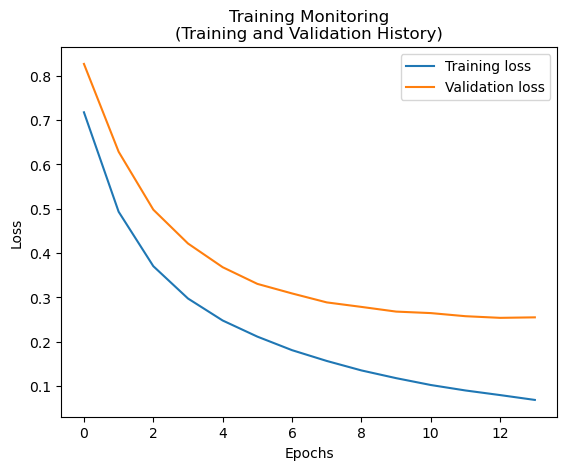

In [22]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History)')
plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [125]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds']) 
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.8637977841483345
Recall: 0.8611111111111112
F1-Score: 0.860497971887365


### Discuss how did you choose model hyperparameters ? 

---
Answer:

The main hapyermeter is potential to be optimized should be learning rate, the embedding size and the drop out rate. 
Here the grid research for parameter will be chose to find the best hyperparameters. 
We used 0.005 and 0.05 for 2 times gap which can be used to find best value caused keeping the cure smooth and dont apper overfitting is fine, 
large learing rate may prevent  to get the best point which has lowest loss. for saving time we will not try small lr.

The second parameter is embedding size, larger dimision may provide better performance but consider the time of computing the value will only start 2 smaller value.

The third parameter is dropping out rate, dropout is a technique to drop selected neurons at any time during training. They are forever "right to drop out". 
This means that their contributions to downstream neurons are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons.

---

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [88]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    w_emb = np.zeros((len(word2id), emb_size))
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [89]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [90]:
# Initialise the weights of your network 
W = network_weights(vocab_size=len(vocab), embedding_dim=300, hidden_dim=[], num_classes=3, init_val = 0.1)

#Replace the weigths of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)


Shape W0 (2893, 300)
Shape W1 (300, 3)


In [100]:
W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.01,
                                       dropout = 0.2, freeze_emb = True,tolerance=0.001,epochs=100)

Epoch: 1 | Training loss: 0.3339518891522692 | Validation loss: 0.23864329644860774
Epoch: 2 | Training loss: 0.3344697730402174 | Validation loss: 0.22058531012868135
Epoch: 3 | Training loss: 0.3251426594521458 | Validation loss: 0.22149267923530022
Early stopping... Validation loss did not improve more than 0.001


In [101]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))


Accuracy: 0.8844444444444445
Precision: 0.8858971223219951
Recall: 0.8844444444444445
F1-Score: 0.8845442428642981


### Discuss how did you choose model hyperparameters ? 

---
Answer:

The main hapyermeter is potential to be optimized should be learning rate, the embedding size and the drop out rate. Here the grid research for parameter will be chose to find the best hyperparameters. We used 0.005 and 0.05 for 2 times gap which can be used to find best value caused keeping the cure smooth and dont apper overfitting is fine, large learing rate may prevent  to get the best point which has lowest loss.

The second parameter is embedding size，but here the size will be fixed to 300 because it is  pre-trained embeddings which limit the option.

The third parameter is dropping out rate，dropout is a technique to drop selected neurons at any time during training. They are forever "right to drop out". This means that their contributions to downstream neurons are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons.

---

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [137]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[150,50],num_classes=3, init_val = 0.1)
W[0] = w_glove
for i in range(len(W)):
    print('Shape of W'+str(i), W[i].shape)
    
W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr= 0.001,dropout=0.1,freeze_emb=True,print_progress=True,
tolerance=-0.03,epochs=100)

Shape of W0 (2893, 300)
Shape of W1 (300, 150)
Shape of W2 (150, 50)
Shape of W3 (50, 3)
Epoch: 1 | Training loss: 1.0924618363313818 | Validation loss: 1.0930076975408012
Epoch: 2 | Training loss: 1.0867682129346699 | Validation loss: 1.0878486769420141
Epoch: 3 | Training loss: 1.0781244010891124 | Validation loss: 1.0797604263200582
Epoch: 4 | Training loss: 1.063694524443857 | Validation loss: 1.0664701620055466
Epoch: 5 | Training loss: 1.038550714040834 | Validation loss: 1.0437492680804443
Epoch: 6 | Training loss: 0.9948735240404134 | Validation loss: 1.0047443581190156
Epoch: 7 | Training loss: 0.918616207943398 | Validation loss: 0.9347259088851378
Epoch: 8 | Training loss: 0.7965630631382518 | Validation loss: 0.8191286354934371
Epoch: 9 | Training loss: 0.6604713701806044 | Validation loss: 0.6781135535055007
Epoch: 10 | Training loss: 0.5428275921376078 | Validation loss: 0.5432215952233153
Epoch: 11 | Training loss: 0.4534459359624236 | Validation loss: 0.4292584805398260

In [138]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8888888888888888
Precision: 0.8885183371317532
Recall: 0.888888888888889
F1-Score: 0.8886693256491807


### Discuss how did you choose model hyperparameters ? 

In [139]:
learning_rate_list = [0.001, 0.01]
drop_out_rate_list = [0.1, 0.2, 0.3]
test_score = []
hyper_list = []
all_list = []

for lr in learning_rate_list:
    for drop in drop_out_rate_list:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[160,40],num_classes=3, init_val = 0.1)
            #Replace the weigths of the embedding matrix with w_glove
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, 
                                   dropout = drop,freeze_emb=False,tolerance=0,epochs=100,print_progress=True)    
        # Results and Scores
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_preds'])+1 for x,y in zip(X_te,Y_te)]
        accuracy = accuracy_score(Y_te,preds_te)
        precision = precision_score(Y_te,preds_te,average='macro')
        Recall =recall_score(Y_te,preds_te,average='macro')
        F_Score =f1_score(Y_te,preds_te,average='macro')
        score = [accuracy, precision, Recall,F_Score]
            
        test_score.append(accuracy)
        all_list.append([accuracy, precision, Recall, F_Score])
        hyper = [lr, drop]
        hyper_list.append(hyper)

Epoch: 1 | Training loss: 1.0929574270730762 | Validation loss: 1.0923079817835295
Epoch: 2 | Training loss: 1.0858855548701296 | Validation loss: 1.0856807822977002
Epoch: 3 | Training loss: 1.0750453020544821 | Validation loss: 1.0755244473729375
Epoch: 4 | Training loss: 1.055817391071171 | Validation loss: 1.0576154740974835
Epoch: 5 | Training loss: 1.0188939337739238 | Validation loss: 1.0235975610575025
Epoch: 6 | Training loss: 0.9503192000184875 | Validation loss: 0.961266249693764
Epoch: 7 | Training loss: 0.8367524282150195 | Validation loss: 0.8568251805369088
Epoch: 8 | Training loss: 0.7007546732260854 | Validation loss: 0.7258778232201583
Epoch: 9 | Training loss: 0.5881850424149166 | Validation loss: 0.6006330442775815
Epoch: 10 | Training loss: 0.5079713854955952 | Validation loss: 0.5165907983605182
Epoch: 11 | Training loss: 0.43295086473673206 | Validation loss: 0.42129164721933404
Epoch: 12 | Training loss: 0.37938597897674337 | Validation loss: 0.34028342563826114

In [212]:
best_result = max(test_score)
best_id = test_score.index(best_result)
best_hyper = hyper_list[best_id]
best_S = all_list[best_id]
print("The best parameter and the F1-score on test set")
print(" lr:", best_hyper[0]," drop_rate:" ,best_hyper[1] ," Accuracy:", best_result, "A/P/R/F",best_S)

The best parameter and the F1-score on test set
 lr: 0.001  drop_rate: 0.2  Accuracy: 0.8944444444444445 A/P/R/F [0.8944444444444445, 0.8941571128669713, 0.8944444444444445, 0.8939764880442845]


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   |   |   |   |
| Average Embedding (Pre-trained)  |   |   |   |   |
| Average Embedding (Pre-trained) + X hidden layers    |   |   |   |   |


Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

---
Answer:

The results of table clear show that the Average Embedding (Pre-trained) + X hidden layers > Average Embedding (Pre-trained) > Average Embedding.

This is reasonable result because Pre_trained model embedding W matrix was train by a large text corpus so it should have better geralization ability and have a better initilization on model when trained.

Deeper architectures architectures has more layers can generate more detials features， the deeper network can also provide modeling of complex nonlinear systems(like this classification NLP problem), and the additional layers provide a higher level of abstraction for the model, thus improving the ability of the model. However this may also have significant increase on the complexity. That may be the reason that we failed to have a large optimisation on grid search.

In general, all model have accurcy higher than 85%， they are all avaliable and preformed good.

---